# FAST-UAV - Multirotor Design Optimization

[FAST-OAD](https://fast-oad.readthedocs.io) is a framework for performing rapid Overall Aircraft Design. The computational core of FAST-OAD is based on the  [OpenMDAO framework](https://openmdao.org/). <br>
FAST-UAV is the drone declination of FAST-OAD.

## 1. Setting up and analyzing the initial problem

To organize our work, we propose to use two user folders `data/` and `workdir/`. For instance, in `data/` we store a XML file which describes the [DJI Matrice 600 Pro](https://www.dji.com/matrice600-pro) multicopter. In `workdir/`, we store files generated or modified by FAST-UAV.

In [1]:
import os.path as pth
import openmdao.api as om
import logging
import shutil
import fastoad.api as oad
from fastuav.cmd.lca import *
from time import time
from IPython.display import IFrame
import matplotlib.pyplot as plt
import brightway2 as bw
from fastuav.utils.postprocessing.analysis_and_plots import *
from fastuav.utils.postprocessing.lca import *

plt.rcParams["figure.figsize"] = 16, 8
plt.rcParams.update({"font.size": 13})

DATA_FOLDER_PATH = "../data"
CONFIGURATIONS_FOLDER_PATH = "../configurations"
WORK_FOLDER_PATH = "./workdir"

CONFIGURATION_FILE = pth.join(WORK_FOLDER_PATH, "multirotor_mdo_lca.yaml")
SOURCE_FILE = pth.join(DATA_FOLDER_PATH, "problem_inputs_lca.xml")

ECOINVENT_PATH = r"D:/THESE/LCA_databases/ecoinvent 3.9_cutoff_ecoSpold02/datasets"   # path to the datasets subfolder; mind that the ecoinvent file must be unzipped.

# For having log messages display on screen
logging.basicConfig(level=logging.INFO, format="%(levelname)-8s: %(message)s")

# For using all screen width
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:95% !important; }</style>"))

C:\Users\f.pollet.ISAE-SUPAERO\AppData\Local\Temp\ipykernel_10800\1569115838.py:30: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
oad.generate_configuration_file(
    CONFIGURATION_FILE, overwrite=True, distribution_name="fastuav", sample_file_name="multirotor_mdo_lca.yaml"
)

INFO    : Loading FAST-OAD plugin uav
INFO    : Loading bundles from fastuav.models
INFO    : Installed bundle fastuav.models.aerodynamics.aerodynamics_fixedwing (ID 12 )
INFO    : Installed bundle fastuav.models.propulsion.propulsion_multirotor (ID 78 )
INFO    : Installed bundle fastuav.models.scenarios.scenarios_fixedwing (ID 80 )
INFO    : Installed bundle fastuav.models.aerodynamics.aerodynamics_hybrid (ID 13 )
INFO    : Installed bundle fastuav.models.aerodynamics.__init__ (ID 15 )
INFO    : Installed bundle fastuav.models.mtow.mtow (ID 24 )
INFO    : Installed bundle fastuav.models.aerodynamics.aerodynamics_multirotor (ID 14 )
INFO    : Installed bundle fastuav.models.mtow.mtow_fixedwing (ID 25 )
INFO    : Installed bundle fastuav.models.performance.mission.mission_builder (ID 30 )
INFO    : Installed bundle fastuav.models.propulsion.motor.definition_parameters (ID 60 )
INFO    : Installed bundle fastuav.models.propulsion.propeller.aerodynamics.__init__ (ID 67 )
INFO    : Instal

'D:\\THESE\\Tools\\FAST-UAV\\src\\fastuav\\notebooks\\workdir\\multirotor_mdo_lca.yaml'

------------------------------
### LCA project setup

The LCA module of FAST-UAV requires the **EcoInvent 3.9** database. You must first download it [here](https://v39.ecoquery.ecoinvent.org/Home/Index), then unzip it in the folder specified by the ECOINVENT_PATH variable.

When it's done, the following line will create a Brightway project for you and import the database. This process takes a few minutes.

Once the project is created and the database imported, you won't have to reinstall it the next times you use this notebook.

In [3]:
create_lca_project(project_name="fastuav", db_path=ECOINVENT_PATH, db_name="ecoinvent 3.9_cutoff_ecoSpold02")

Biosphere database already present!!! No setup is needed
"ecoinvent 3.9_cutoff_ecoSpold02" database already present!!! No setup is needed
Available projects on your computer: 
 [Project: default, Project: StepByStep, Project: BW2 introduction, Project: bw2_seminar_2017, Project: bw2_uav, Project: bw2_uav_2, Project: fastuav, Project: fastua2v]
Available databases in project "fastuav": 
 ['biosphere3', 'ecoinvent 3.9_cutoff_ecoSpold02', 'Foreground DB']


---------------
The YAML configuration file located in the data folder defines the design problem, i.e. the model, the problem driver and the optimization problem definition.<br>
A useful feature is the [N2 diagram](http://openmdao.org/twodocs/versions/latest/basic_guide/make_n2.html) visualization available in OpenMDAO to see the structure of the model:

In [4]:
N2_FILE = pth.join(WORK_FOLDER_PATH, "n2.html")
oad.write_n2(CONFIGURATION_FILE, N2_FILE, overwrite=True)
IFrame(src=N2_FILE, width="100%", height="500px")

INFO    : N2 diagram written in D:\THESE\Tools\FAST-UAV\src\fastuav\notebooks\workdir\n2.html


In [5]:
LCA_FILE = pth.join(WORK_FOLDER_PATH, "LCA_processes.html")
net = graph_activities(CONFIGURATION_FILE)
net.show(LCA_FILE)

In the configuration file, we have specified an input file name 'problem_inputs.xml'. We can ask FAST-UAV to generate the inputs of the model with the reference parameters from 'problem_inputs_DJI_M600.xml' as default values:

In [6]:
oad.generate_inputs(CONFIGURATION_FILE, SOURCE_FILE, overwrite=True)

INFO    : Problem inputs written in D:\THESE\Tools\FAST-UAV\src\fastuav\notebooks\workdir\problem_inputs.xml


'D:\\THESE\\Tools\\FAST-UAV\\src\\fastuav\\notebooks\\workdir\\problem_inputs.xml'

You can now checkout the generated [input file](./workdir/problem_inputs.xml). The values in this file can be modified by the user and will be considered by FAST-UAV when executing a computational process.<br>
The `variable-viewer` provides a way to inspect and modify the content of the XML file. The dropdown lists above the table allow to filter the displayed variable.

In [7]:
INPUT_FILE = pth.join(WORK_FOLDER_PATH, "problem_inputs.xml")
oad.variable_viewer(INPUT_FILE)

## 2. Running an MDO

You can now run an optimization problem. The last part of the configuration file .yaml is where this optimization problem is defined:

```yaml
optimization:
  design_variables:
    - name: data:weights:mtow:k # over estimation coefficient on the load mass
      upper: 40.0
      lower: 1.0
  constraints:
    - name: data:weights:mtow:guess:constraint # mass consistency
      lower: 0.0
  objective:
    - name: data:weights:mtow
      scaler: 1e-1
```

In [8]:
eval_problem = oad.evaluate_problem(CONFIGURATION_FILE, overwrite=True)

INFO    : Computation finished after 0.57 seconds
INFO    : Problem outputs written in D:\THESE\Tools\FAST-UAV\src\fastuav\notebooks\workdir\problem_outputs.xml


In [9]:
optim_problem = oad.optimize_problem(CONFIGURATION_FILE, overwrite=True)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.4067043949577624
            Iterations: 13
            Function evaluations: 14
            Gradient evaluations: 13
Optimization Complete
-----------------------------------


INFO    : Computation finished after 16.66 seconds
INFO    : Problem outputs written in D:\THESE\Tools\FAST-UAV\src\fastuav\notebooks\workdir\problem_outputs.xml


Let's save these results:

In [10]:
OUTPUT_FILE = pth.join(WORK_FOLDER_PATH, "problem_outputs.xml")
MDO_OUTPUT_FILE = pth.join(DATA_FOLDER_PATH, 'problem_outputs_lca_mdo.xml')
shutil.copy(OUTPUT_FILE, MDO_OUTPUT_FILE)

'../data\\problem_outputs_lca_mdo.xml'

The `optimizer_viewer` offers a convenient summary of the optimization result. If design variables or constraints have active bounds they are yellow whereas they are red if they are violated.

In [11]:
oad.optimization_viewer(CONFIGURATION_FILE)

D:\Softwares\Miniconda3\envs\FAST-UAV\lib\site-packages\jupyter_client\session.py:719: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


You can use the `VariableViewer` tool to see the optimization results for all variables of the system by loading the .xml output file:

In [12]:
oad.variable_viewer(MDO_OUTPUT_FILE)

## 3. Running a new LCA with updated parameters
...But with the same UAV design. For instance, you may want to change the UAV's lifetime or the electricity mix to study the effect of these parameters on the environmental impacts.

First, we load the configuration file containing only the LCA module:

In [25]:
CONFIGURATION_FILE_LCA_ONLY = pth.join(WORK_FOLDER_PATH, "multirotor_lca.yaml")
oad.generate_configuration_file(
    CONFIGURATION_FILE_LCA_ONLY, overwrite=True, distribution_name="fastuav", sample_file_name="multirotor_lca.yaml"
)

INFO    : Sample configuration written in "D:\THESE\Tools\FAST-UAV\src\fastuav\notebooks\workdir\multirotor_lca.yaml".


'D:\\THESE\\Tools\\FAST-UAV\\src\\fastuav\\notebooks\\workdir\\multirotor_lca.yaml'

And we generate the input file for the LCA based on the previous output file:

In [26]:
oad.generate_inputs(CONFIGURATION_FILE_LCA_ONLY, MDO_OUTPUT_FILE, overwrite=True)

Db Foreground DB was here. Reseting it
Db Foreground DB was here. Reseting it
INFO    : Problem inputs written in D:\THESE\Tools\FAST-UAV\src\fastuav\notebooks\workdir\problem_inputs.xml


'D:\\THESE\\Tools\\FAST-UAV\\src\\fastuav\\notebooks\\workdir\\problem_inputs.xml'

Let's check the inputs of the LCA module. You can fill in the new values for the LCA parameters.

In [27]:
INPUT_FILE = pth.join(WORK_FOLDER_PATH, "problem_inputs.xml")
oad.variable_viewer(INPUT_FILE)

D:\Softwares\Miniconda3\envs\FAST-UAV\lib\site-packages\jupyter_client\session.py:719: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



Finally, we run the LCA module with the updated parameters.

In [28]:
eval_problem = oad.evaluate_problem(CONFIGURATION_FILE_LCA_ONLY, overwrite=True)

Db Foreground DB was here. Reseting it
Db Foreground DB was here. Reseting it
Db Foreground DB was here. Reseting it
Db Foreground DB was here. Reseting it
Db Foreground DB was here. Reseting it
Db Foreground DB was here. Reseting it
Db Foreground DB was here. Reseting it
Db Foreground DB was here. Reseting it
INFO    : Created LCA object
INFO    : {'message': 'Started MultiLCA calculation', 'methods': [('ReCiPe 2016 v1.03, midpoint (E) no LT', 'climate change no LT', 'global warming potential (GWP1000) no LT'), ('ReCiPe 2016 v1.03, midpoint (E) no LT', 'acidification: terrestrial no LT', 'terrestrial acidification potential (TAP) no LT'), ('ReCiPe 2016 v1.03, midpoint (E) no LT', 'water use no LT', 'water consumption potential (WCP) no LT'), ('ReCiPe 2016 v1.03, midpoint (E) no LT', 'material resources: metals/minerals no LT', 'surplus ore potential (SOP) no LT')], 'functional units': [[{'database': 'ecoinvent 3.9_cutoff_ecoSpold02', 'code': '52e3cdd70890530eada4fbcef2741406', 'amount

In [29]:
OUTPUT_FILE = pth.join(WORK_FOLDER_PATH, "problem_outputs.xml")
LCA_OUTPUT_FILE = pth.join(DATA_FOLDER_PATH, 'problem_outputs_lca.xml')
shutil.copy(OUTPUT_FILE, LCA_OUTPUT_FILE)

'../data\\problem_outputs_lca.xml'

In [30]:
oad.variable_viewer(LCA_OUTPUT_FILE)

## 4. Analysis and plots

You can now use postprocessing plots to visualize the results of the MDO.

### 4.1 - Geometry and mass breakdown

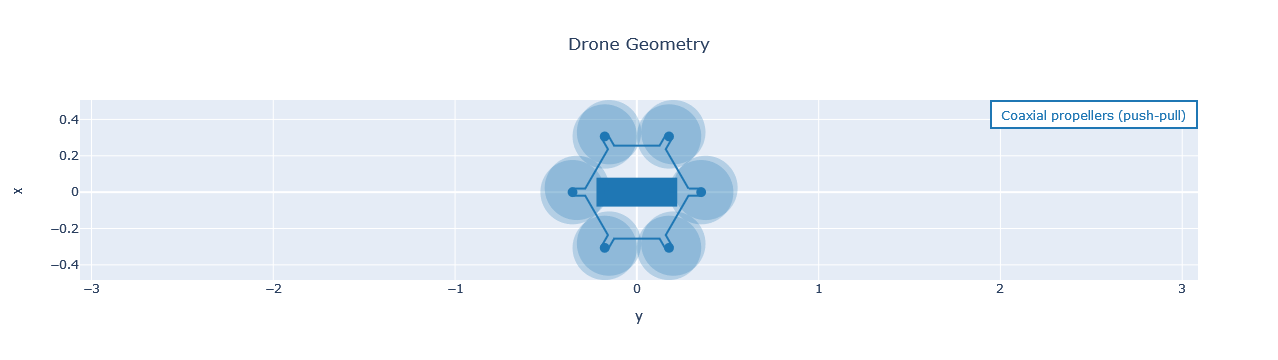

In [31]:
fig = multirotor_geometry_plot(MDO_OUTPUT_FILE, name="Drone MDO")
fig.show()

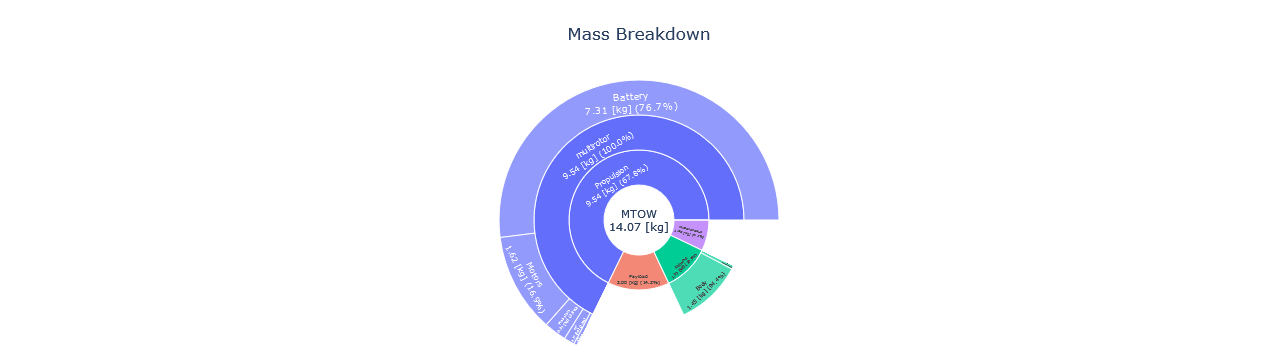

In [32]:
fig = mass_breakdown_sun_plot_drone(MDO_OUTPUT_FILE)
fig.show()

### 4.2 - LCA results

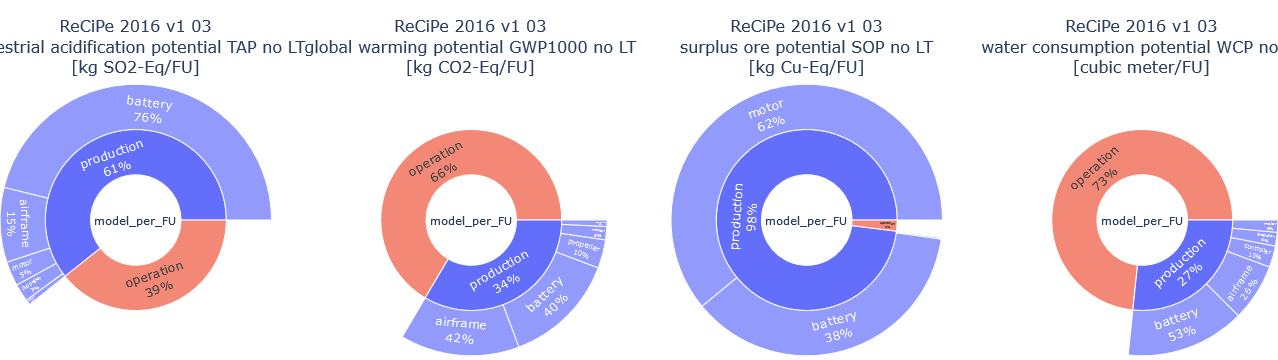

In [33]:
fig = lca_sun_plot(OUTPUT_FILE)
fig.show()

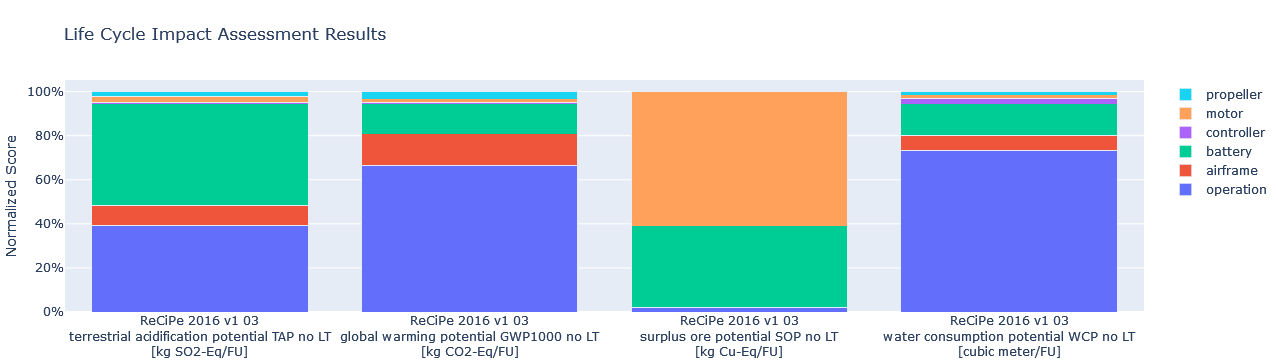

In [36]:
fig = lca_bar_plot(OUTPUT_FILE, normalize = True)  # normalize is recommended for comparing different impact categories
fig.show()

#### **Splitting "operation" contribution into terms related to the components' masses and efficiencies.**

This analysis of the specific component contributions is only valid for cruise conditions.

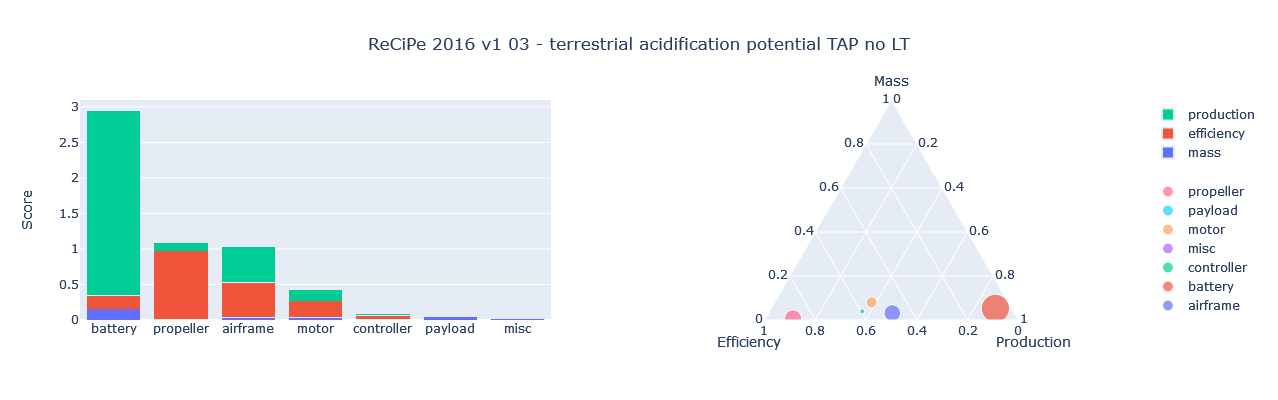

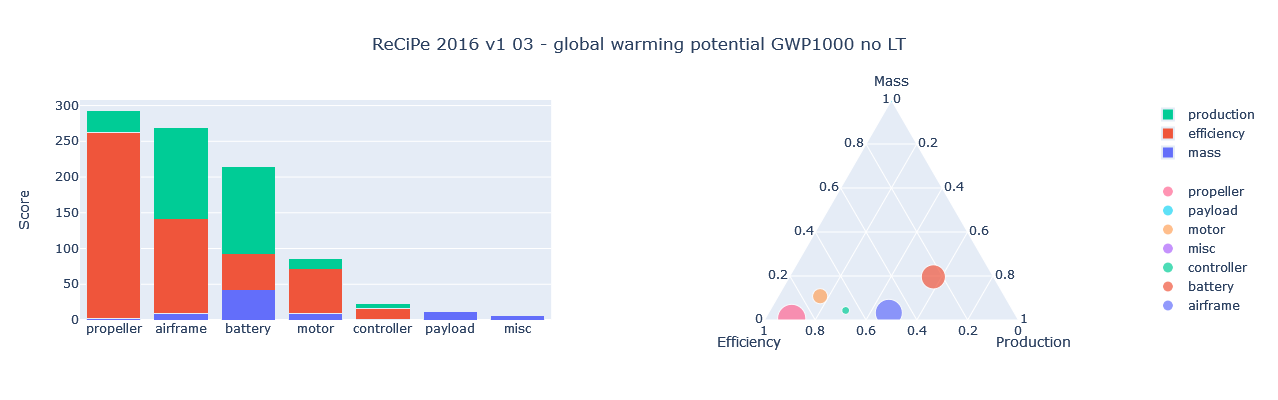

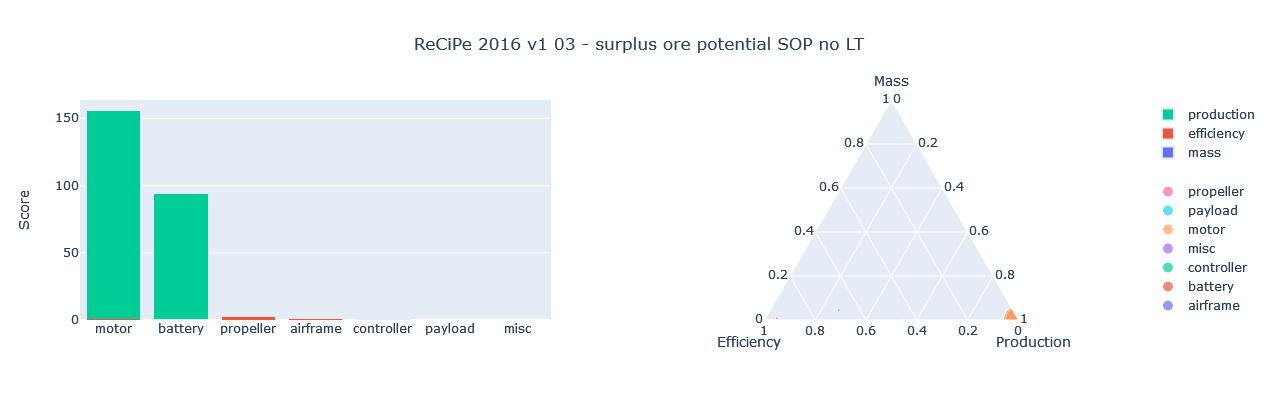

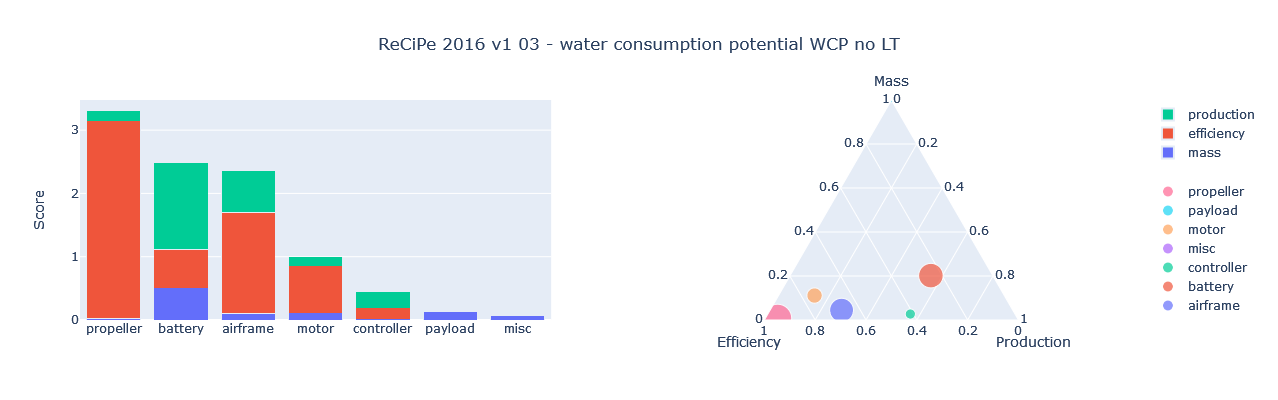

In [37]:
figs = lca_specific_contributions(OUTPUT_FILE)  # plot_type="sunburst" or "ternary" or "bar"
for fig in figs:
    fig.show()

### 4.3 - Advanced LCA studies

In [106]:
# get all activities created in LCA module
activities = get_lca_activities()
activities

['propeller' (kg, GLO, None),
 'battery' (kilogram, GLO, None),
 'production' (uav, GLO, None),
 'airframe' (kg, GLO, None),
 'controller' (kg, GLO, None),
 'operation' (kilowatt hour, GLO, None),
 'model' (uav lifetime, GLO, None),
 'model per FU' (kg.km, GLO, None),
 'motor' (kg, GLO, None)]

In [107]:
# select top-level activity (model)
model = get_lca_main_activity()
model

'model per FU' (kg.km, GLO, None)

In [100]:
# get a particular activity
from fastuav.constants import LCA_USER_DB
test = lcalg.getActByCode(LCA_USER_DB, 'production')

In [29]:
# Another way of visualizing interactions
recursive_activities(model)

activity  \
model per FU                                                                             model per FU   
model                                                                                           model   
production                                                                                 production   
battery                                                                                       battery   
market for battery cell, Li-ion, NMC811                       market for battery cell, Li-ion, NMC811   
market for battery cell, Li-ion, NMC111                       market for battery cell, Li-ion, NMC111   
market for battery cell, Li-ion, NCA                             market for battery cell, Li-ion, NCA   
market for battery cell, Li-ion, LFP                             market for battery cell, Li-ion, LFP   
market for battery, NiMH, rechargeable, prismatic   market for battery, NiMH, rechargeable, prismatic   
motor                                                                                           motor   
market for electric motor, for electric scooter       market for electric motor, for electric scooter   
airframe                                                                                     airframe   
market for carbon fibre reinforced plastic, inj...  market for carbon fibre reinforced plastic, in...   
propeller                                                                                   propeller   
market for carbon fibre reinforced plastic, inj...  market for carbon fibre reinforced plastic, in...   
controller                                                                                 controller   
market for controller, for electric scooter               market for controller, for electric scooter   
operation                                                                                   operation   
market group for electricity, low voltage [US]         market group for electricity, low voltage [US]   
market group for electricity, low voltage [Euro...  market group for electricity, low voltage [Eur...   
market for electricity, low voltage [FR]                     market for electricity, low voltage [FR]   

                                                             unit  \
model per FU                                                 kg.h   
model                                                uav lifetime   
production                                                    uav   
battery                                                  kilogram   
market for battery cell, Li-ion, NMC811                  kilogram   
market for battery cell, Li-ion, NMC111                  kilogram   
market for battery cell, Li-ion, NCA                     kilogram   
market for battery cell, Li-ion, LFP                     kilogram   
market for battery, NiMH, rechargeable, prismatic        kilogram   
motor                                                          kg   
market for electric motor, for electric scooter          kilogram   
airframe                                                       kg   
market for carbon fibre reinforced plastic, inj...       kilogram   
propeller                                                      kg   
market for carbon fibre reinforced plastic, inj...       kilogram   
controller                                                     kg   
market for controller, for electric scooter              kilogram   
operation                                           kilowatt hour   
market group for electricity, low voltage [US]      kilowatt hour   
market group for electricity, low voltage [Euro...  kilowatt hour   
market for electricity, low voltage [FR]            kilowatt hour   

                                                                      location  \
model per FU                                                               GLO   
model                                                                      GLO   
production       

In [30]:
# list available parameters
list_lca_parameters()

#### Simple DoE at LCA level

DoE on LCA parameters.

**Warning:** here no iteration on the design is made. DoE on the design plus the LCA can be made by hand or with a DoE on the whole FAST-UAV model. See further below.

In [38]:
import lca_algebraic as lcalg
from fastoad.io import VariableIO
from fastuav.constants import LCA_PARAM_KEY, LCA_USER_DB

# Select activities/model to explore
model = lcalg.getActByCode(LCA_USER_DB, 'model per FU')
operation = lcalg.getActByCode(LCA_USER_DB, 'operation')
production = lcalg.getActByCode(LCA_USER_DB, 'production')

In [39]:
# Get parameters values from problem outputs
variables = VariableIO(OUTPUT_FILE).read()
param_names = [p for p in variables.names() if p.startswith(LCA_PARAM_KEY)]
parameters = {}
for p in param_names:
    parameters[p.replace(LCA_PARAM_KEY, "")] = variables[p].value[0]
parameters

{'mass_airframe': 1.531686070568789,
 'mass_batteries': 7.31466494082726,
 'mass_controllers': 0.17348743243553683,
 'mass_motors': 1.6152013881993112,
 'mass_payload': 2.0,
 'mass_propellers': 0.36543086280121173,
 'mission_distance': 20.0,
 'mission_duration': 0.38888888888888895,
 'mission_energy': 0.5940343893969786,
 'n_cycles_battery': 1500.0,
 'n_cycles_uav': 2600.0}

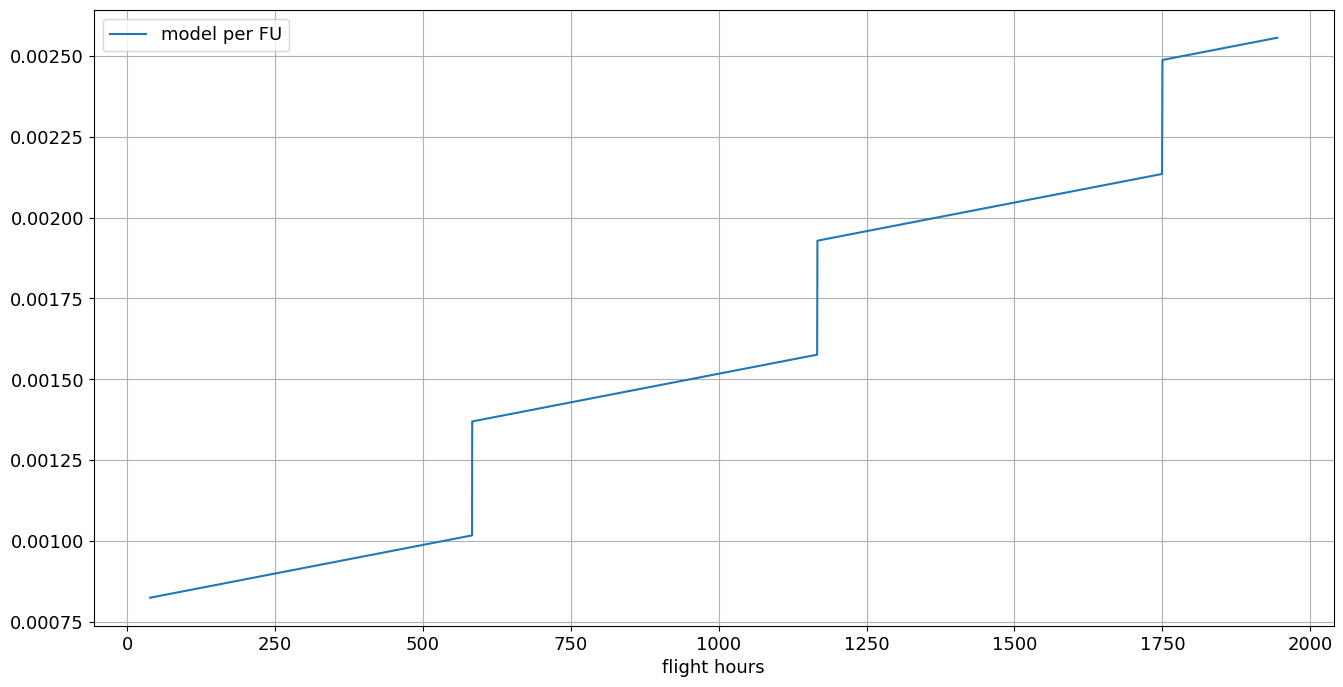

In [42]:
# Set non-float parameters
parameters['elec_switch_param'] = "fr"
parameters['battery_type'] = "lfp"

# Modify parameter of interest
parameters['n_cycles_uav'] = list(np.geomspace(100.0, 5000, 10000))

# Choose lcia method
# method = [('ReCiPe 2016 v1.03, midpoint (E) no LT', 'climate change no LT', 'global warming potential (GWP1000) no LT')]
method = [('ReCiPe 2016 v1.03, endpoint (H) no LT', 'total: human health no LT', 'human health no LT')]

# activities and sub-activities to evaluate
activities = [model]  # [operation, production]

# Run LCA. The DoE is automatically performed.
data = {'n_cycles_uav': parameters['n_cycles_uav']}
for act in activities:
    res = lcalg.multiLCAAlgebric(
        act, # The model 
        method, # Impacts
        
        # Parameters of the model
        **parameters
    )
    data[act.as_dict()['name']] = res.iloc[:, 0].values
df = pd.DataFrame(data=data, index=parameters['n_cycles_uav'])
df['flight hours'] = df['n_cycles_uav'] * parameters['mission_duration']
df['functional_value'] = df['n_cycles_uav'] * parameters['mission_duration'] * parameters['mass_payload']
df.to_csv(pth.join(DATA_FOLDER_PATH, 'lca_cycles_lfp_fr_endpoint.csv'))

#df['model per FU'] = df['model per FU'] / df['functional_value']
#df['operation'] = df['operation'] / df['functional_value']
#df['production'] = df['production'] / df['functional_value']

ax = df.plot(x='flight hours', y=['model per FU'], grid=True)
plt.show()

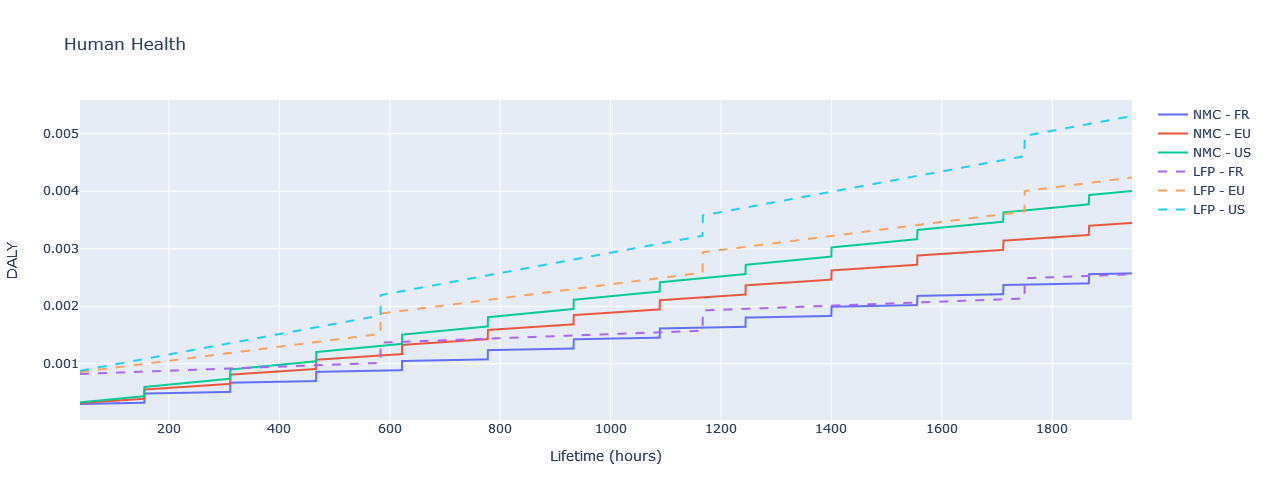

In [46]:
import pandas as pd
import plotly.graph_objects as go

# dict for the dataframes and their names
dfs_NMC = {"NMC - FR": pd.read_csv(pth.join(DATA_FOLDER_PATH, 'lca_cycles_nmc811_fr_endpoint.csv')),
           "NMC - EU": pd.read_csv(pth.join(DATA_FOLDER_PATH, 'lca_cycles_nmc811_eu_endpoint.csv')),
           "NMC - US" : pd.read_csv(pth.join(DATA_FOLDER_PATH, 'lca_cycles_nmc811_us_endpoint.csv')),
          }
dfs_LFP = {"LFP - FR" : pd.read_csv(pth.join(DATA_FOLDER_PATH, 'lca_cycles_lfp_fr_endpoint.csv')),
           "LFP - EU" : pd.read_csv(pth.join(DATA_FOLDER_PATH, 'lca_cycles_lfp_eu_endpoint.csv')),
           "LFP - US" : pd.read_csv(pth.join(DATA_FOLDER_PATH, 'lca_cycles_lfp_us_endpoint.csv')),
          }

# plot the data
fig = go.Figure()

for i in dfs_NMC:
    fig = fig.add_trace(go.Scatter(x = dfs_NMC[i]["flight hours"],
                                   y = dfs_NMC[i]["model per FU"], 
                                   name = i,
                                   line = dict(width=2)))
for i in dfs_LFP:
    fig = fig.add_trace(go.Scatter(x = dfs_LFP[i]["flight hours"],
                                   y = dfs_LFP[i]["model per FU"], 
                                   name = i,
                                   line = dict(width=2, dash='dash')))

fig.update_layout(title='Human Health', #Global Warming Potential',
                   xaxis_title='Lifetime (hours)',
                   yaxis_title='DALY', #kgCO2eq/FU',
                  width=900,
                  height=500,)
fig.show()

### Draft

In [70]:
# Set non-float parameters
parameters['elec_switch_param'] = "eu"

# Modify parameter of interest
parameters['n_cycles'] = list(np.geomspace(1.0, 5000, 10000))

# Choose lcia method
method = [('ReCiPe 2016 v1.03, midpoint (E) no LT', 'climate change no LT', 'global warming potential (GWP1000) no LT')]
method = [('ReCiPe 2016 v1.03, midpoint (E) no LT', 'acidification: terrestrial no LT', 'terrestrial acidification potential (TAP) no LT')]

# activities and sub-activities to evaluate
activities = [operation, production]

# Have a look to NiMH batteries
# Run LCA. The DoE is automatically performed.
data = {'n_cycles': parameters['n_cycles']}
parameters['battery_type'] = "nmc_811"
parameters['n_cycles_battery'] = 1000
for act in activities:
    res = lcalg.multiLCAAlgebric(
        act, # The model 
        method, # Impacts
        
        # Parameters of the model
        **parameters
    )
    data[act.as_dict()['name']] = res.iloc[:, 0].values
df1 = pd.DataFrame(data=data, index=parameters['n_cycles'])
df1['flight hours'] = df1['n_cycles'] * parameters['mission_duration']
df1['operation'] = 0.6 * df1['operation']
df1['model'] = df1['operation'] + df1['production']
df1['functional_value'] = df1['n_cycles'] * parameters['mission_duration'] * parameters['mass_payload']

# Do the same with Li-ion batteries
data = {'n_cycles': parameters['n_cycles']}
parameters['battery_type'] = "lfp"
parameters['n_cycles_battery'] = 3000
for act in activities:
    res = lcalg.multiLCAAlgebric(
        act, # The model 
        method, # Impacts
        
        # Parameters of the model
        **parameters
    )
    data[act.as_dict()['name']] = res.iloc[:, 0].values
df2 = pd.DataFrame(data=data, index=parameters['n_cycles'])
df2['flight hours'] = df2['n_cycles'] * parameters['mission_duration']
df2['model'] = df2['operation'] + df2['production']
df2['functional_value'] = df2['n_cycles'] * parameters['mission_duration'] * parameters['mass_payload']

#df['model'] = df['model'] / df['functional_value']
#df['operation'] = df['operation'] / df['functional_value']
#df['production'] = df['production'] / df['functional_value']

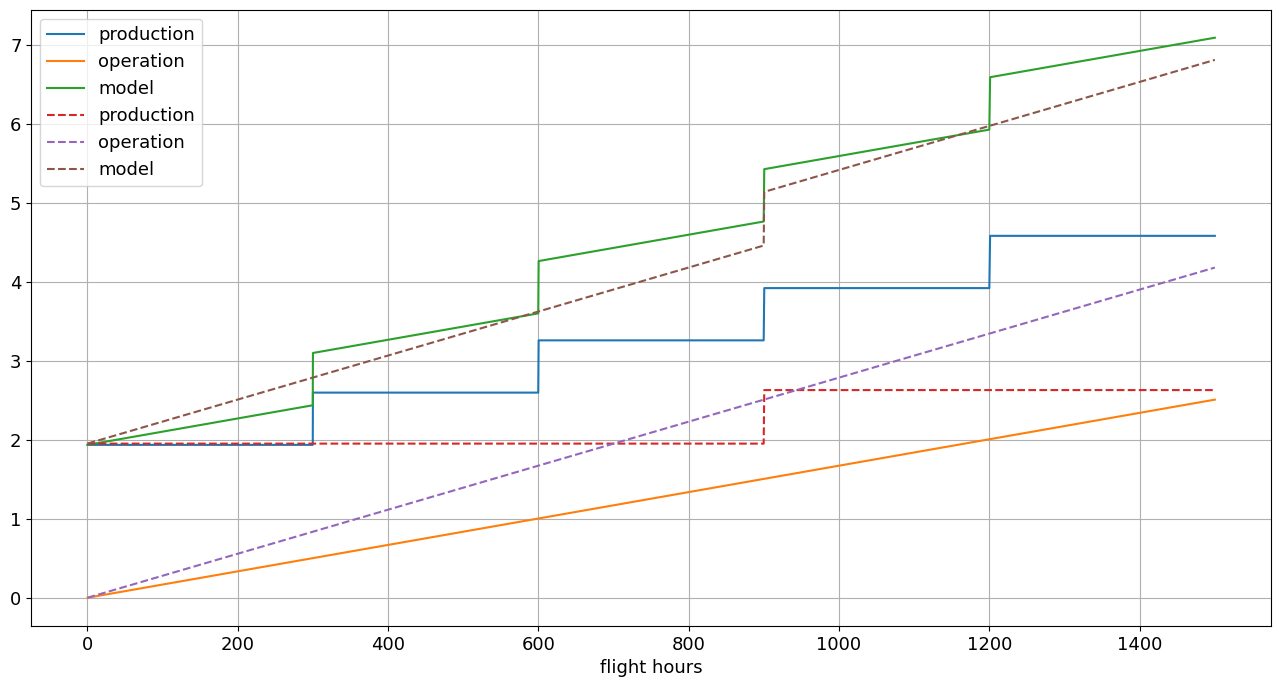

In [71]:
#df.plot(x='flight hours', y=['model', 'operation', 'production'], grid=True)

ax = df1.plot(x='flight hours', y=['production', 'operation', 'model'])
df2.plot(ax=ax, x='flight hours', y=['production', 'operation', 'model'], style=['--', '--', '--'], grid=True)
plt.show()

#### Monte Carlo

In [43]:
from fastoad.io import VariableIO
from fastuav.constants import PARAM_VARIABLE_KEY

# Select model
model = get_lca_main_activity()  # top-level model

# Get parameters values from problem outputs
variables = VariableIO(DJI_M600_OUTPUT_FILE).read()
param_names = [p for p in variables.names() if p.startswith(PARAM_VARIABLE_KEY)]
parameters = {}
for p in param_names:
    parameters[p.replace(PARAM_VARIABLE_KEY, "")] = variables[p].value[0]

# Choose method
method = ('ReCiPe 2016 v1.03, midpoint (E) no LT', 'climate change no LT', 'global warming potential (GWP1000) no LT')

# Mixed DoE + Monte Carlo
scores = {}
#for elec in list(["eu", "us", "fr"]):  # DoE
#    parameters["elec_switch_param"] = elec  # Set DoE parameter

parameters["elec_switch_param"] = "fr"
for bat in list(["li_ion", "nimh"]):
    parameters["battery_type"] = bat
    if bat == "li_ion":
        parameters["n_cycles_battery"] = 800
    else:
        parameters["n_cycles_battery"] = 1200
    
    # Run Monte Carlo
    res = LCAMonteCarlo(
        model, # the model
        method, # impacts to assess 

        # Number of Monte Carlo runs
        n_runs=1000, 

        # Parameters of the model
        **parameters
    )
    scores[bat] = res[0]  # score distribution

INFO    : Created LCA object
INFO    : Seeded RNGs


Freezing 'production' (uav, GLO, None) // battery : mass_batteries => 3
Freezing 'production' (uav, GLO, None) // motor : mass_motors => 1
Freezing 'production' (uav, GLO, None) // airframe : mass_airframe => 2
Freezing 'production' (uav, GLO, None) // propeller : mass_propellers => 0
Freezing 'production' (uav, GLO, None) // controller : mass_controllers => 0
Freezing 'model per UF' (kg.h, GLO, None) // model : 1/(mass_payload*mission_duration*n_cycles) => 0
Freezing 'battery' (kilogram, GLO, None) // market for battery, Li-ion, NMC811, rechargeable, prismatic : battery_type_li_ion*ceiling(n_cycles/n_cycles_battery) => 3
Freezing 'battery' (kilogram, GLO, None) // market for battery, NiMH, rechargeable, prismatic : battery_type_nimh*ceiling(n_cycles/n_cycles_battery) => 0
Freezing 'operation' (kilowatt hour, GLO, None) // market group for electricity, low voltage : elec_switch_param_us*mission_energy*n_cycles => 0
Freezing 'operation' (kilowatt hour, GLO, None) // market group for ele

INFO    : Created LCA object
INFO    : Seeded RNGs


Freezing 'production' (uav, GLO, None) // battery : mass_batteries => 3
Freezing 'production' (uav, GLO, None) // motor : mass_motors => 1
Freezing 'production' (uav, GLO, None) // airframe : mass_airframe => 2
Freezing 'production' (uav, GLO, None) // propeller : mass_propellers => 0
Freezing 'production' (uav, GLO, None) // controller : mass_controllers => 0
Freezing 'battery' (kilogram, GLO, None) // market for battery, Li-ion, NMC811, rechargeable, prismatic : battery_type_li_ion*ceiling(n_cycles/n_cycles_battery) => 0
Freezing 'battery' (kilogram, GLO, None) // market for battery, NiMH, rechargeable, prismatic : battery_type_nimh*ceiling(n_cycles/n_cycles_battery) => 2
Freezing 'model per UF' (kg.h, GLO, None) // model : 1/(mass_payload*mission_duration*n_cycles) => 0
Freezing 'operation' (kilowatt hour, GLO, None) // market group for electricity, low voltage : elec_switch_param_us*mission_energy*n_cycles => 0
Freezing 'operation' (kilowatt hour, GLO, None) // market group for ele

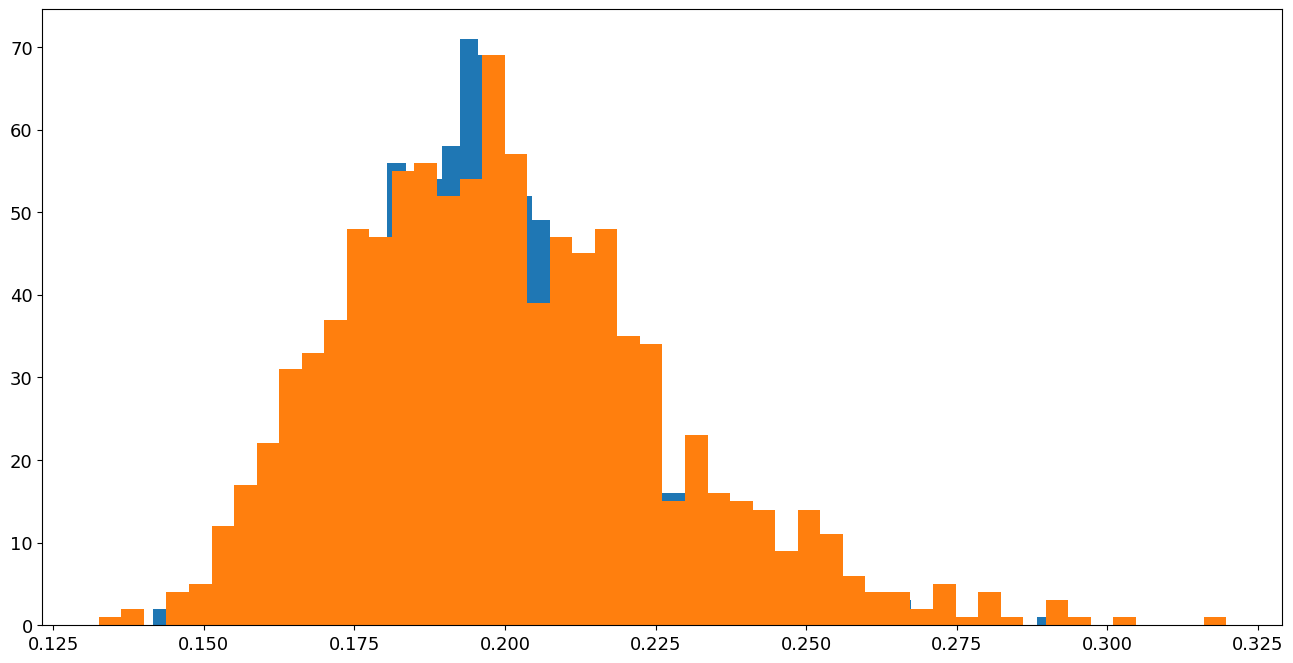

In [44]:
# plot distributions
for k, v in scores.items():
    plt.hist(v, bins=50);    
plt.show()